In [22]:
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import load_target_sample

In [23]:
target = load_target_sample()
target.head()

,Season,team_a,team_b,in_target
ID,,,,
2014_1107_1110,2014,1107,1110,True
2014_1107_1112,2014,1107,1112,True
2014_1107_1113,2014,1107,1113,True
2014_1107_1124,2014,1107,1124,True
2014_1107_1140,2014,1107,1140,True


In [25]:
ncaa_games = pd.read_csv('data/NCAATourneyCompactResults.csv')
ncaa_games = ncaa_games.astype({
    'LTeamID': str,
    'WTeamID': str,
    'Season': str
})
ncaa_games['diff'] = ncaa_games['WScore'] - ncaa_games['LScore']
print(ncaa_games.shape)
ncaa_games.sample()

(2117, 9)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff
800,1997,139,1344,98,1181,87,N,0,11


In [117]:
regular_games = pd.read_csv('data/RegularSeasonCompactResults.csv')
regular_games = regular_games.astype({
    'LTeamID': str,
    'WTeamID': str,
    'Season': str
})
regular_games['diff'] = regular_games['WScore'] - regular_games['LScore']
print(regular_games.shape)
regular_games.sample()

(150684, 9)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff
122731,2012,103,1411,72,1212,54,H,0,18


In [124]:
# data = pd.concat([ncaa_games, regular_games])
data = cp.deepcopy(ncaa_games)
data['team_a'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) < int(t[1]) else t[1], axis=1)
data['team_b'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) > int(t[1]) else t[1], axis=1)
data['a_win'] = data['WTeamID'] == data['team_a']
data = data[['Season', 'team_a', 'team_b', 'a_win']]
data = pd.concat([data, target.reset_index(drop=True)]).fillna(0).astype({'a_win': bool, 'in_target': bool})

lags = 3
for team, opponent_team in [('a', 'b'), ('b','a')]:
    pass 
    
data = data.dropna()
data.head(5)

,Season,a_win,in_target,team_a,team_b
0,1985,True,False,1116,1234
1,1985,True,False,1120,1345
2,1985,True,False,1207,1250
3,1985,True,False,1229,1425
4,1985,True,False,1242,1325


In [125]:
from sklearn.datasets import dump_svmlight_file
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder


libfm_feature_cols = ['Season', 'team_a', 'team_b']
X = data[~data.in_target.astype(bool)][libfm_feature_cols]
X_enc = OneHotEncoder().fit_transform(X)
y = data[~data.in_target.astype(bool)][['a_win']].values.reshape(-1)

path = 'data/libfm/cv_{}-{:d}-of-3-shuffle.{}'
kf = KFold(n_splits=3, shuffle=True)
metrics = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    with open(path.format("train", i, "libfm"),'wb') as f:
        dump_svmlight_file(X_enc[train_index], y[train_index], f)
        
    with open(path.format("test", i, "libfm"),'wb') as f:
        dump_svmlight_file(X_enc[test_index], 0.5*np.ones(X_enc[test_index].shape[0]), f)
        
    !dist/libfm/bin/LibFM\
        -task c\
        -test data/libfm/cv_test-{i}-of-3-shuffle.libfm\
        -train data/libfm/cv_train-{i}-of-3-shuffle.libfm \
        -verbosity 0\
        -out data/libfm/predictions.csv\
        -iter 50\
        -init_stdev .5
        
    preds = np.loadtxt('data/libfm/predictions.csv')
    metric = log_loss(y[test_index], preds)
    metrics.append(metric)
    
!ls data/libfm/
print('Metric Mean: {:.2f} ({:.2f})'.format(np.mean(metrics), np.std(metrics)))

----------------------------------------------------------------------------
libFM
  Version: 1.4.4
  Author:  Steffen Rendle, srendle@libfm.org
  WWW:     http://www.libfm.org/
This program comes with ABSOLUTELY NO WARRANTY; for details see license.txt.
This is free software, and you are welcome to redistribute it under certain
conditions; for details see license.txt.
----------------------------------------------------------------------------
Loading train...	
has x = 0
has xt = 1
num_rows=1411	num_values=4233	num_features=512	min_target=0	max_target=1
Loading test... 	
has x = 0
has xt = 1
num_rows=706	num_values=2118	num_features=512	min_target=0.5	max_target=0.5
#relations: 0
Loading meta data...	
#Iter=  0	Train=0.642098	Test=0.516997	Test(ll)=0.428429
#Iter=  1	Train=0.704465	Test=0.555241	Test(ll)=0.362273
#Iter=  2	Train=0.736357	Test=0.536827	Test(ll)=0.337341
#Iter=  3	Train=0.739901	Test=0.525496	Test(ll)=0.333676
#Iter=  4	Train=0.759745	Test=0.529745	Test(ll)=0.326915
#It

#Iter= 37	Train=0.791785	Test=0.49078	Test(ll)=0.327813
#Iter= 38	Train=0.791785	Test=0.493617	Test(ll)=0.327482
#Iter= 39	Train=0.803116	Test=0.486525	Test(ll)=0.327562
#Iter= 40	Train=0.800283	Test=0.486525	Test(ll)=0.327038
#Iter= 41	Train=0.791076	Test=0.483688	Test(ll)=0.326839
#Iter= 42	Train=0.791785	Test=0.483688	Test(ll)=0.326513
#Iter= 43	Train=0.810198	Test=0.486525	Test(ll)=0.326393
#Iter= 44	Train=0.790368	Test=0.489362	Test(ll)=0.325544
#Iter= 45	Train=0.803824	Test=0.502128	Test(ll)=0.324852
#Iter= 46	Train=0.791785	Test=0.499291	Test(ll)=0.324455
#Iter= 47	Train=0.775496	Test=0.502128	Test(ll)=0.324169
#Iter= 48	Train=0.786827	Test=0.50922	Test(ll)=0.324008
#Iter= 49	Train=0.804533	Test=0.504965	Test(ll)=0.324172
cv_test-0-of-3-shuffle.csv    cv_train-1-of-3-shuffle.libfm
cv_test-0-of-3-shuffle.libfm  cv_train-2-of-3-shuffle.libfm
cv_test-1-of-3-shuffle.csv    predictions.csv
cv_test-1-of-3-shuffle.libfm  test.cv
cv_test-2-of-3-shuffle.csv    test.libfm
cv_test-2-of-3-s

In [126]:
X_sub = data[data.in_target.astype(bool)].drop(['a_win', 'in_target'], axis=1)
X_sub_enc = OneHotEncoder().fit_transform(X_sub)
y_sub = data[data.in_target.astype(bool)][['Season', 'team_a', 'team_b', 'a_win', 'in_target']]

with open('data/libfm/train.libfm','wb') as f:
    dump_svmlight_file(X_enc, y, f)
    
with open('data/libfm/test.libfm','wb') as f:
    dump_svmlight_file(X_sub_enc, y_sub['a_win'].values, f)

!dist/libfm/bin/LibFM\
    -task c\
    -test data/libfm/test.libfm\
    -train data/libfm/train.libfm \
    -verbosity 0\
    -out data/libfm/predictions.csv\
    -iter 50\
    -init_stdev .5

preds = np.loadtxt('data/libfm/predictions.csv')

sub = cp.deepcopy(y_sub)
sub['Pred'] = preds
sub['ID'] = sub['Season'].map(str) + '_' + sub['team_a'].map(str) + '_' + sub['team_b'].map(str)
sub.set_index('ID', inplace=True)
sub.drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1, inplace=True)
sub.head()

----------------------------------------------------------------------------
libFM
  Version: 1.4.4
  Author:  Steffen Rendle, srendle@libfm.org
  WWW:     http://www.libfm.org/
This program comes with ABSOLUTELY NO WARRANTY; for details see license.txt.
This is free software, and you are welcome to redistribute it under certain
conditions; for details see license.txt.
----------------------------------------------------------------------------
Loading train...	
has x = 0
has xt = 1
num_rows=2117	num_values=6351	num_features=512	min_target=0	max_target=1
Loading test... 	
has x = 0
has xt = 1
num_rows=9112	num_values=27336	num_features=296	min_target=0	max_target=0
#relations: 0
Loading meta data...	
#Iter=  0	Train=0.65659	Test=0.494622	Test(ll)=0.445657
#Iter=  1	Train=0.72461	Test=0.471356	Test(ll)=0.363441
#Iter=  2	Train=0.75059	Test=0.498573	Test(ll)=0.339637
#Iter=  3	Train=0.740198	Test=0.49572	Test(ll)=0.33619
#Iter=  4	Train=0.737364	Test=0.505048	Test(ll)=0.329207
#Iter=  5	

,Pred
ID,
2014_1107_1110,0.569450
2014_1107_1112,0.512263
2014_1107_1113,0.580663
2014_1107_1124,0.513015
2014_1107_1140,0.560870


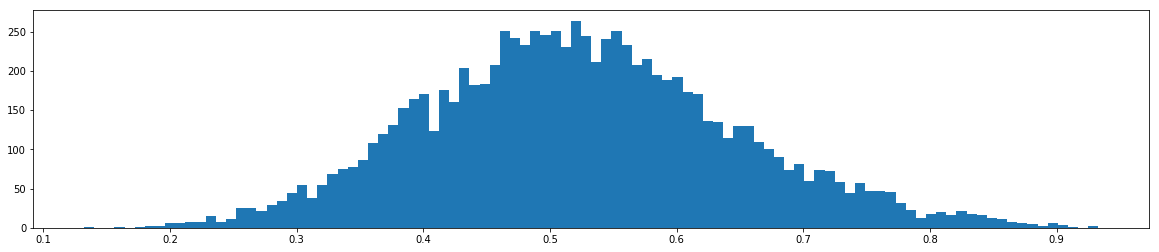

In [127]:
plt.figure(figsize=(20,4))
plt.hist(sub['Pred'], bins=100)
plt.show()

In [128]:
sub.to_csv('submissions/libfm_baseline_2.csv')